- Autor: Manuel David Alcantara
- Correo: manuel.alcantara@pe.ibm.com

# Sistema de Recomendación

Los Sistemas de Recomendación intentan personalizar al máximo lo que ofrecerán a cada usuario.

<div class="alert alert-block alert-info">
    
* <b>BASADOS EN CONTENIDO:</b> A partir de productos visitados por el usuario, se intenta “adivinar” qué busca el usuario y ofrecer mercancías similares.

* <b>POPULARIDAD:</b> Recomienda productos según su popularidad. Por ejemplo: Los más vendidos globalmente serán ofrecidos por igual a todos los usuarios.

* <b>COLABORATIVOS:</b> Utiliza la información de su población de clientes para identificar perfiles similares. Luego "aprende" de estos datos para recomendar productos de manera individual.Existe dos tipos:<br/><br/>
    * <b>Basados en Usuario</b>:
        1. Se identifican usuarios similares.
        * Se recomiendan nuevos ítems a otros usuarios basado en el rating dado por otros usuarios similares (que no haya valorado este usuario).<br/><br/>
    
    * <b>Basados en Artículo</b>:
        1. Calcular la similitud entre items.
        * Encontrar los “mejores items similares” a los que un usuario no tenga evaluados y recomendárselos.
    
</div>

## Veamos el caso

<div class="alert alert-block alert-info">
En el siguiente caso desarrollaremos un <b>Filtro Colaborativo Basado en Usuario</b> donde mostraremos el puntaje de un conjunto de <b>Productos Financieros</b> establecido por cada <b>Cliente</b>.
    
    
* <b>Clientes</b>: 200 clientes
* <b>Puntuación de productos</b>: 1 - 5 (0: No compró el producto)
* <b>Productos</b>: 7 productos:
    1. Fondos Mutuos
    * Asesoría de Inversión
    * Crédito Educativo
    * Crédito Vehicular
    * Préstamo Personal
    * Cuenta Corriente
    * Cuenta de Ahorros
    
    

 
</div>


<div class="alert alert-block alert-success">
<b>NOTA</b>: Usaremos:

* Datasets:
    * <b>Products</b>(7, 2): productID, product
    * <b>Ratings</b>(14000, 3): customerID, productID, rating

    
* Matrices:
    * <b>Matriz Rating</b> (2000, 7): La Matriz Rating contiene la calificación de los productos por cada cliente.
    * <b>Matriz de Similitud</b>(2000, 2000): La Matriz la Similitud calcula puntajes de similidud entre los clientes usando Distancia de Coseno para establecer la similitud.
    * <b>Matriz de Recomendaciones</b>: Producto de multiplicar la Matriz Rating por la Matriz la Similitud.
</div>

## 1. Carguemos las librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
import seaborn as sns

#palette = 'Blues'
palette = 'cool'

## 2. Veamos los datos

Dataset de Productos:

In [2]:
df_products = pd.read_csv('data/products.csv')
df_products

,productID,product
0,1,Fondos Mutuos
1,2,Asesoría de Inversión
2,3,Crédito Educativo
3,4,Crédito Vehicular
4,5,Préstamo Personal
5,6,Cuenta Corriente
6,7,Cuenta de Ahorros


In [3]:
df_products.shape

(7, 2)

Dataset de calificaciones (ratings):

In [4]:
df_ratings = pd.read_csv('data/ratings.csv')
df_ratings.head()

,customerID,productID,rating
0,5409,1,4
1,5477,1,4
2,5507,1,3
3,8,1,3
4,158,1,1


In [5]:
df_ratings.shape 

(14000, 3)

In [6]:
n_users = df_ratings.customerID.unique().shape[0]
n_products = df_products.productID.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_products) + ' products')

2000 users
7 products


<div class="alert alert-block alert-success">
<b>NOTA</b>: 

* [1-5]: Calificaciones a los productos
* 0: No ha comprado producto  
</div>

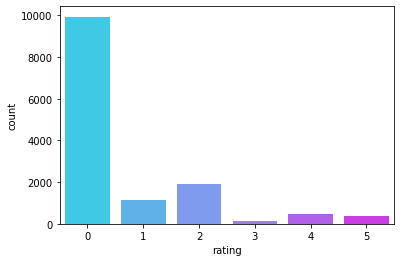

In [7]:
sns.countplot(x='rating', data=df_ratings, palette=palette)

In [8]:
df_ratings["rating"].value_counts(sort=False, normalize=True) * 100

0    70.935714
1     8.128571
2    13.771429
3     1.050000
4     3.307143
5     2.807143
Name: rating, dtype: float64

## 3. Matriz Rating: Construcción (customerID vs productID)

<div class="alert alert-block alert-warning">
La <b>Matriz Rating</b> contiene la calificación de los productos por cada cliente.
</div>

In [9]:
df_matrix = pd.pivot_table(df_ratings, values='rating', index='customerID', columns='productID').fillna(0)
df_matrix

productID,1,2,3,4,5,6,7
customerID,,,,,,,
8,3,2,4,1,5,1,3
37,3,2,4,1,5,1,3
53,0,0,0,0,0,0,0
93,1,1,1,3,1,5,1
104,0,0,0,0,2,0,1
...,...,...,...,...,...,...,...
96719,5,1,1,0,1,5,3
97262,0,0,1,0,0,0,0
97412,4,0,0,0,0,5,5


<div class="alert alert-block alert-success">
<b>NOTA</b>: La matriz tiene valores ceros los cuales serán reemplazados por recomendaciones.
</div>

## 4. Porcentaje de dispersión en Matriz Rating (sparsity)

Veamos el porcentaje de dispersión (sparsity):

In [10]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
no_sparsity = 100 - sparsity
print('Sparsity: {:4.2f}% porcentaje de valores no ceros en la matriz'.format(sparsity))
print('Ceros: {:4.2f}% porcentaje de valores ceros en la matriz'.format(no_sparsity))

Sparsity: 29.06% porcentaje de valores no ceros en la matriz
Ceros: 70.94% porcentaje de valores ceros en la matriz


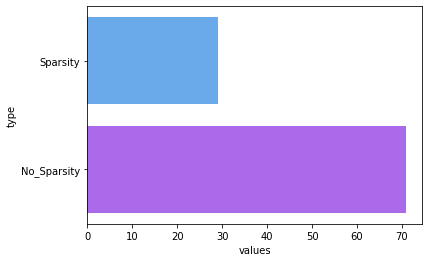

In [11]:
d = {'type':['Sparsity','No_Sparsity'], 'values': [sparsity, no_sparsity]}
sp_df = pd.DataFrame(data=d)
sns.barplot(x='values',y='type', data=sp_df, palette=palette)

## 5. Matriz Rating: Identificando vectores

Volvamos a visualizar la puntuación de productos de los 4 primeros clientes.

In [12]:
df_matrix.head(4)

productID,1,2,3,4,5,6,7
customerID,,,,,,,
8,3,2,4,1,5,1,3
37,3,2,4,1,5,1,3
53,0,0,0,0,0,0,0
93,1,1,1,3,1,5,1


![title](images/01-rating.png)

<div class="alert alert-block alert-success">
<b>NOTA</b>:
    
1. El cliente ID <b>8</b> y el cliente ID <b>37</b> han calificado idénticamente a los 7 productos. 
* El cliente ID <b>53</b> no tiene calificaciones registradas.
* El cliente ID <b>93</b> tiene calificaciones registradas diferentes a los clientes con ID <b>8</b> y <b>37</b>.
    
</div>

## 6. Matriz de Similitud: Construcción (customerID vs customerID)

<div class="alert alert-block alert-warning">
La <b>Matriz la Similitud</b> calcula puntajes de similidud entre los clientes según la puntuación que le dieron a los productos.

Usa el cálculo de <b>Distancia de Coseno</b> para establecer la similitud.
</div>

![title](images/02-coseno.png)

In [13]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
print(sim_matrix.shape)

(2000, 2000)


Para mejor entendimiento, agreguemos los ID de Clientes:

In [14]:
sm_ix_col = df_matrix.index.tolist()

df_sim_matrix = pd.DataFrame(sim_matrix, columns = sm_ix_col, index = sm_ix_col)
df_sim_matrix

,8,37,53,93,104,158,173,202,311,323,...,96056,96133,96176,96274,96599,96719,97262,97412,97487,97651
8,1.000000,1.000000,0.0,0.496536,0.721110,0.460132,0.613349,0.701646,0.372104,0.372104,...,0.516734,0.496139,0.898795,0.668319,0.602094,0.630097,0.496139,0.488564,0.467979,0.666795
37,1.000000,1.000000,0.0,0.496536,0.721110,0.460132,0.613349,0.701646,0.372104,0.372104,...,0.516734,0.496139,0.898795,0.668319,0.602094,0.630097,0.496139,0.488564,0.467979,0.666795
53,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
93,0.496536,0.496536,0.0,1.000000,0.214834,0.803685,0.769835,0.226455,0.160128,0.480384,...,0.687948,0.160128,0.671775,0.373878,0.496609,0.732107,0.160128,0.670154,0.823853,0.506370
104,0.721110,0.721110,0.0,0.214834,1.000000,0.390360,0.245718,0.948683,0.000000,0.000000,...,0.000000,0.000000,0.554322,0.160644,0.241209,0.283981,0.000000,0.275241,0.306786,0.282843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96719,0.630097,0.630097,0.0,0.732107,0.283981,0.748270,0.645458,0.359211,0.635001,0.296334,...,0.628292,0.127000,0.847629,0.250909,0.205496,1.000000,0.127000,0.937958,0.914774,0.883541
97262,0.496139,0.496139,0.0,0.160128,0.000000,0.000000,0.549442,0.000000,0.000000,0.000000,...,0.260378,1.000000,0.476731,0.898027,0.674200,0.127000,1.000000,0.000000,0.000000,0.316228
97412,0.488564,0.488564,0.0,0.670154,0.275241,0.644658,0.676317,0.435194,0.492366,0.164122,...,0.480754,0.000000,0.704179,0.088432,0.165977,0.937958,0.000000,1.000000,0.907731,0.895274
97487,0.467979,0.467979,0.0,0.823853,0.306786,0.898177,0.659600,0.363803,0.342997,0.114332,...,0.446544,0.000000,0.752180,0.092406,0.115624,0.914774,0.000000,0.907731,1.000000,0.705024


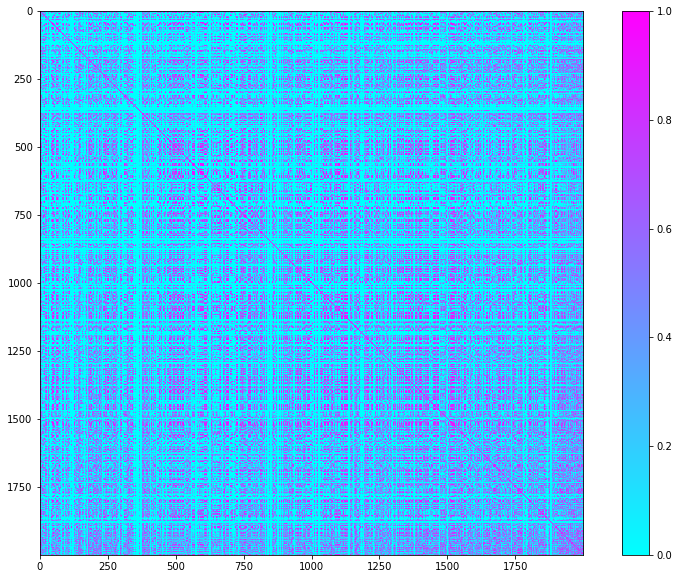

In [15]:
plt.rcParams["figure.figsize"] = (14,10)
plt.imshow(df_sim_matrix, cmap = palette);
plt.colorbar()
plt.show()

Visualicemos la similitud de los 4 primeros clientes:

In [16]:
df_sim_matrix.iloc[0:4, 0:4]

,8,37,53,93
8,1.000000,1.000000,0.0,0.496536
37,1.000000,1.000000,0.0,0.496536
53,0.000000,0.000000,1.0,0.000000
93,0.496536,0.496536,0.0,1.000000


## 7. Matriz de Similitud: Clienes ID: 8, 37, 53 & 93

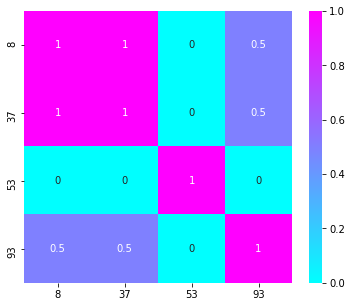

In [17]:
plt.rcParams["figure.figsize"] = (6,5)

corrMatrix = df_sim_matrix.iloc[0:4, 0:4]
sns.heatmap(corrMatrix, annot=True, cmap = palette)
plt.show()

<div class="alert alert-block alert-success">
<b>NOTA</b>:
    
* Cuanto más cercano a 1, mayor similitud entre esos clientes.
* Cuanto más cercano a 0, menor similitud entre esos clientes.
</div>

## 8. Dividiendo Matriz Rating en Train y Test

![title](images/03-rating-train-test.png)

In [18]:
ratings.shape

(2000, 7)

### Matriz Rating - Train/Test

In [19]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(1600, 7)
(400, 7)


## 9. Dividiendo Matriz Similitud en Train y Test

![title](images/04-similitud-train-test.png)

### Matriz Similitud - Train

In [20]:
sim_matrix_train = sim_matrix[0:1600,0:1600]
print(sim_matrix_train.shape)

(1600, 1600)


### Matriz Similitud - Test

In [21]:
sim_matrix_test = sim_matrix[1600:2000,1600:2000]
print(sim_matrix_test.shape)

(400, 400)


## 10. Matriz de Recomendaciones

<div class="alert alert-block alert-warning">
La <b>Matriz de Recomendaciones</b> contiene el producto de multiplicar la Matriz Rating por la Matriz la Similitud.
</div>

Matrices: 

* ratings_train
* ratings_test
* sim_matrix_train
* sim_matrix_test

![title](images/05-similitud_rating.png)

### Matriz Recomendación - Train

In [22]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T
print(users_predictions.shape)
print(users_predictions)

(1600, 7)
[[0.618543   0.41949567 0.4929434  ... 0.67057915 0.70199143 1.25400056]
 [0.618543   0.41949567 0.4929434  ... 0.67057915 0.70199143 1.25400056]
 [0.         0.         0.         ... 0.         0.         2.        ]
 ...
 [0.66933597 0.48320257 0.50207066 ... 0.68324165 0.66620742 1.25687378]
 [0.6094915  0.42309754 0.48874973 ... 0.67069164 0.69288115 1.24825044]
 [0.         0.         2.         ... 0.         0.         3.        ]]


In [69]:
up_ix = sm_ix_col[:1600]
up_cols = df_products['product'].tolist()

df_users_predictions = pd.DataFrame(users_predictions, columns = up_cols, index = up_ix)
df_users_predictions

,Fondos Mutuos,Asesoría de Inversión,Crédito Educativo,Crédito Vehicular,Préstamo Personal,Cuenta Corriente,Cuenta de Ahorros
8,0.618543,0.419496,0.492943,0.425927,0.670579,0.701991,1.254001
37,0.618543,0.419496,0.492943,0.425927,0.670579,0.701991,1.254001
53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
93,0.672361,0.384407,0.478295,0.448120,0.679402,0.669372,1.214819
104,0.592172,0.408540,0.504991,0.416883,0.664175,0.720322,1.262576
...,...,...,...,...,...,...,...
71054,0.591662,0.416504,0.498780,0.429029,0.674533,0.716326,1.264744
71116,0.644112,0.403187,0.477671,0.397466,0.643115,0.722388,1.230284
71173,0.669336,0.483203,0.502071,0.438052,0.683242,0.666207,1.256874
71301,0.609492,0.423098,0.488750,0.425676,0.670692,0.692881,1.248250


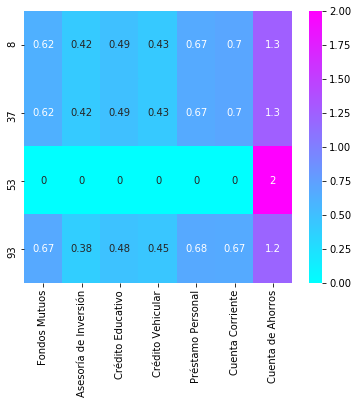

In [24]:
plt.rcParams["figure.figsize"] = (6,5)

corrMatrix_up = df_users_predictions.iloc[:4]
sns.heatmap(corrMatrix_up, annot=True, cmap = palette)
plt.show()

## 11. Recomendación de Productos por ID Cliente

<div class="alert alert-block alert-warning">
Para este caso evaluaremos la recomendación de productos del cliente con <b>ID 8</b>.

</div>

In [25]:
ID_USUARIO_EJEMPLO = 8

Revisión de datos generales del cliente ID 8.

In [26]:
df_bank = pd.read_csv('data/Data_set_platzi.csv')
data = df_bank[df_bank['Customer ID'] == ID_USUARIO_EJEMPLO]
data

,Customer ID,Age,Age_BIN,Months as a Customer,Number of Products,RFM Score,Average Balance Feed Index,Number of Transactions,Personal Debt to Equity Ratio,Months Current Account,...,Age Youngest Child,Number of Workers in Household,Percentage White Collar Workers,Household Debt to Equity Ratio,Income,Weeks Since Last Offer,Homeowner,Annual value,Accepted Home Equity Loan,Accepted Credit Card
3,8,59,56-60,0,0,0.0,0,1,45,3,...,15,7,30,62,82831,51,F,0,F,F


### Obtención de puntaje de Productos por ID Cliente:

Revisión de puntajes de productos en la Matriz de Recomendación para el cliente ID 8.

In [27]:
row_user_pred = df_users_predictions.loc[ [ID_USUARIO_EJEMPLO]]
row_user_pred

,Fondos Mutuos,Asesoría de Inversión,Crédito Educativo,Crédito Vehicular,Préstamo Personal,Cuenta Corriente,Cuenta de Ahorros
8,0.618543,0.419496,0.492943,0.425927,0.670579,0.701991,1.254001


| 1 | 2 | 3 | 4 | 5 | 6 |
| : | : | : | : | : | : |
| Asesoría de Inversión | Crédito Vehicular | Crédito Educativo | Fondos Mutuos | Cuenta Corriente | Cuenta de Ahorros |
| 0.419496 | 0.425927 | 0.492943 | 0.618543 | 0.701991 | 1.254001 |


In [28]:
row_user_pred_np = row_user_pred.to_numpy()
row_user_pred_np

array([[0.618543  , 0.41949567, 0.4929434 , 0.42592676, 0.67057915,
        0.70199143, 1.25400056]])

### Ordenamiento de puntaje de Productos por ID Cliente:

Obtener posición de ordenamiento de la calificación de productos.

In [82]:
user_prod_order = row_user_pred_np.argsort()[0]
user_prod_order

array([1, 3, 2, 0, 4, 5, 6], dtype=int64)

### Recomendación de los 3 productos con mayor puntuación:

In [90]:
pd.DataFrame(df_users_predictions.loc[8]).T

,Fondos Mutuos,Asesoría de Inversión,Crédito Educativo,Crédito Vehicular,Préstamo Personal,Cuenta Corriente,Cuenta de Ahorros
8,0.618543,0.419496,0.492943,0.425927,0.670579,0.701991,1.254001


In [91]:
df_users_predictions.to_csv('score.csv')

-----------------